# Model Evaluation
In this notebook, we delve into an analysis of the outcomes derived from testing the Ecosystem model. The primary objective of this model is to furnish a prioritized roster of potential customers for engagement in the marketing campaign, predicated on their likelihood of subscribing to a term deposit.

In [1]:
from time import time
import pickle as pkl

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from sklearn.metrics import classification_report

In [4]:
import import_ipynb
from ecosystem_classifier import EcosystemClassifier

importing Jupyter notebook from ecosystem_classifier.ipynb


In [5]:
timer_start = time()

We begin by importing the results of the Ecosystem model over the test set (see **ml_modeling.jpynb**).

In [6]:
with open(file="test_results.pkl",
          mode="rb") as test_results:
    model_results = pkl.load(file=test_results)

x_test = model_results["x_test"]
y_test = model_results["y_test"]
ecosystem = model_results["ecosystem_classifier"]
random_forest = model_results["random_forest_classifier"]
results = model_results["results"]

## Training Evaluation
Initially, we depict the timeline of loss evaluation across objective function calls for the Random Forests that form the core of the Ecosystem model.

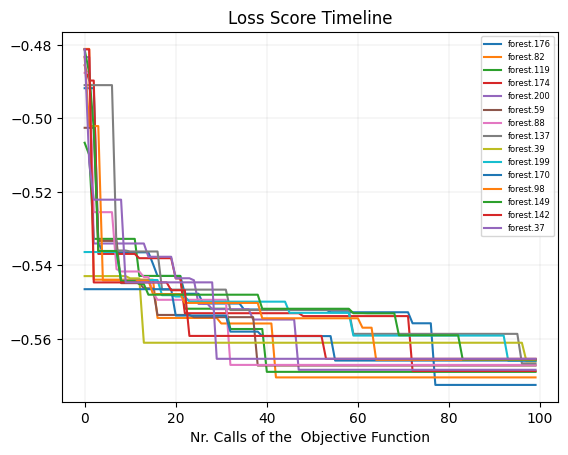

In [7]:
nr_calls = range(results[list(results.keys())[0]].shape[0])

for forest, loss in results.items():
    y_axis = [min(loss[: call + 1]) for call in nr_calls]
    plt.plot(nr_calls, y_axis,
             label=forest)

plt.title("Loss Score Timeline")
plt.xlabel("Nr. Calls of the  Objective Function")
plt.grid(c="grey",
         lw=.1)
plt.legend(prop={'size': 6})
plt.show()

## Performance of the Model
The core aim of this model is to provide a systematically ranked list of prospective customers who are most likely to engage with the marketing campaign by subscribing to a term deposit. To achieve this goal, we sort the test results based on their prediction probabilities.

In [8]:
df_test = pd.concat(objs=[x_test,
                          y_test],
                    axis=1)
df_test["y_pred"] = ecosystem.predict_proba(x_test)
df_test.sort_values(by="y_pred",
                    ascending=False,
                    inplace=True)
ecosystem_test = df_test.y

We repeat the process for a simple Random Forest Classifier for comparison purposes.

In [9]:
df_test = pd.concat(objs=[x_test,
                          y_test],
                    axis=1)
df_test["y_pred"] = [proba[1] for proba in random_forest.predict_proba(x_test)]
df_test.sort_values(by="y_pred",
                    ascending=False,
                    inplace=True)
random_forest_test = df_test.y

Next, we construct a lift chart to illustrate how accurately the model performs across different percentiles of the ranked list of potential customers.

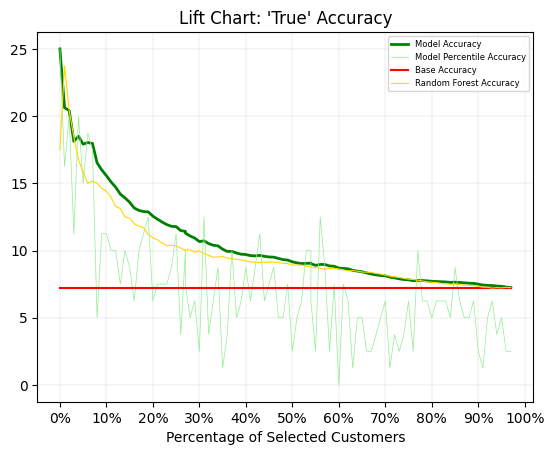

In [10]:
nr_entries = 100
percentiles = {round(percent, 2): int(percent * ecosystem_test.shape[0]) 
               for percent in [1 / nr_entries * (x + 1) 
                               for x in range(nr_entries)]}
x_axis = [f"{int(percent * 100)}%" 
          for percent in percentiles]

true_accuracy_cumulative, true_accuracy_percentile = [], []
random_forest_cumulative = []
previous_nr_customers = 0

for percent, nr_customers in percentiles.items():
    true_accuracy_cumulative.append(ecosystem_test.iloc[: nr_customers].sum() 
                                    / nr_customers * 100)
    random_forest_cumulative.append(random_forest_test.iloc[: nr_customers].sum() 
                                    / nr_customers * 100)
    true_accuracy_percentile.append(ecosystem_test.iloc[previous_nr_customers: nr_customers].sum() 
                                    / (nr_customers - previous_nr_customers) * 100)
    previous_nr_customers = nr_customers

true_accuracy_cumulative = np.array(true_accuracy_cumulative)
random_forest_cumulative = np.array(random_forest_cumulative)

plt.title("Lift Chart: 'True' Accuracy")
plt.xlabel("Percentage of Selected Customers")
plt.xticks(ticks=[int(percent * 100) 
                  for percent in [.1 * x 
                                  for x in range(11)]],
           labels=[f"{int(percent * 100)}%" 
                   for percent in [.1 * x 
                                   for x in range(11)]])

plt.plot(x_axis, true_accuracy_cumulative, 
         label="Model Accuracy", 
         c="green", 
         lw=2)
plt.plot(x_axis, true_accuracy_percentile, 
         label="Model Percentile Accuracy", 
         c="lightgreen", 
         lw=.5)
plt.plot(x_axis, ecosystem_test.sum() / nr_customers * 100 * np.ones(nr_entries), 
         label="Base Accuracy", 
         c="red")
plt.plot(x_axis, random_forest_cumulative, 
         label="Random Forest Accuracy", 
         c="gold", 
         lw=.8)

plt.grid(c="grey", lw=.1)
plt.legend(prop={'size': 6})
plt.show()

Now, we'll develop a gain chart to showcase the effectiveness of the model across various percentiles of the prioritized list of potential customers.

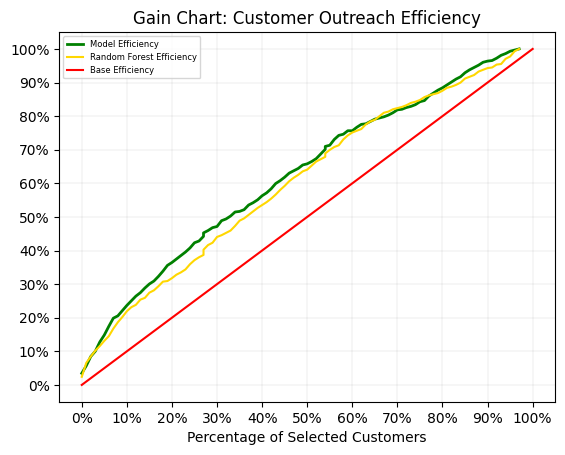

In [11]:
total_true = ecosystem_test.sum()

contacted_true_cumulative = []
random_forest_cumulative = []
for percent, nr_customers in percentiles.items():
    contacted_true_cumulative.append(ecosystem_test.iloc[: nr_customers].sum() / total_true * 100)
    random_forest_cumulative.append(random_forest_test.iloc[: nr_customers].sum() / total_true * 100)

contacted_true_cumulative = np.array(contacted_true_cumulative)
random_forest_cumulative = np.array(random_forest_cumulative)

plt.title("Gain Chart: Customer Outreach Efficiency")
plt.xlabel("Percentage of Selected Customers")
plt.xticks(ticks=[int(percent * 100) for percent in [.1 * x for x in range(11)]],
           labels=[f"{int(percent * 100)}%" for percent in [.1 * x for x in range(11)]])
plt.yticks(ticks=[int(percent * 100) for percent in [.1 * x for x in range(11)]],
           labels=[f"{int(percent * 100)}%" for percent in [.1 * x for x in range(11)]])
plt.plot(x_axis, contacted_true_cumulative, 
         label="Model Efficiency", 
         c="green", 
         lw=2)
plt.plot(x_axis, random_forest_cumulative, 
         label="Random Forest Efficiency", 
         c="gold")
plt.plot([0, 100], 
         [0, 100], 
         label="Base Efficiency", 
         c="red")

plt.grid(c="grey", lw=.1)
plt.legend(prop={'size': 6})
plt.show()

## Concluisions

1. The model demonstrates an accuracy of over **15%** in identifying customers likely to subscribe to a term loan within the top 10% of the highest ranked potential customers, peaking at **25%** accuracy. It's important to note that this represents a significant improvement over the baseline accuracy of **7%**.
2. The efficiency of customer outreach facilitated by the model improves the baseline by an impressive **+150%** within the top 10% of the highest ranked potential customers. Additionally, by reaching out to just **31%** of the total list of potential customers, **50%** of the total amount of possible subscribers to a term loan can be successfully contacted.
3. Eventually, the model significantly outperforms the results obtained by a simpler Random Forest Classifier. For example, the model improves the efficency of the Random Forest Classifier by **20%** in the top 20% of the highest ranked potential customers.

Furthermore, the model includes a feature importance analysis tool that not only enriches the depth of insights garnered from the overall analysis but also presents valuable avenues for refining business strategies and decision-making processes. Notably, balance commands **45%** of the decision-making weight within the model, while age accounts for **25%** of this weight, indicating their significant influence.

In [12]:
feature_importance = ecosystem.feature_importance(feature_names=x_test.columns)

feature_importance.rename(columns={"relevance": "Relevance %"},
                         inplace=True)

In [13]:
feature_importance.head().apply(func=lambda x: round(x * 100, 1))

,Relevance %
balance,44.8
age,25.2
education,4.9
housing,3.4
loan,3.1


In [14]:
print(f"Total running time of the script: {time() - timer_start: .2f}s")

Total running time of the script:  1.53s
